#### 검색어를 입력받아서 Naver News를 crawling하여, json 파일로 저장하고 WordCloud를 생성하기
1. 검색어 입력받기
1. Naver News Crawling하기
1. json 파일로 저장하기
1. 검색 결과에서 본문만 가져와서 명사 빈도수 찾기
1. 명사 빈도수에 기반하여 WordCloud 생성하기

In [1]:
import os
import sys
import urllib.request
import json
import datetime
import re

from konlpy.tag import Okt
from collections import Counter

from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
# 상수 데이터 설정
client_id = "8DsCtOkhPlgBYLeuNgpG"
client_secret = "x33pj1vVn2"
const_url = "https://openapi.naver.com/v1/search/news?query=" # JSON 결과
const_start = 1
const_display = 100

In [3]:
#######################################################
#네이버 뉴스를 검색하여, json형태로 검색 결과 return
def searchNaverNews(keyword, start, display):

# query string 생성
    encText = urllib.parse.quote(keyword)
    reqUrl = const_url+f"{encText}&start={start}&display={display}"
    
# Request 객체 생성
    request = urllib.request.Request(reqUrl)
    request.add_header("X-Naver-Client-Id",client_id)
    request.add_header("X-Naver-Client-Secret",client_secret)
    
# Request 객체의 urlopen을 실행하여 Response 받기
    result_json = None
    try:
        response = urllib.request.urlopen(request)
        rescode = response.getcode()
# Response 객체에서 검색 결과 얻어서 json으로 변환하기
        if(rescode==200):
            response_body = response.read()
            response_body_dec = response_body.decode('utf-8')
            result_json = json.loads(response_body_dec)
    except Exception as e:
        print(e)
        print(f"Error :{reqUrl}")

# 검색이 진행되는 상황 logging 하기
    if (result_json != None):
        print(f"{keyword} [{start}] : Search Request Succes")
    else:
        print(f"{keyword} [{start}] : Error~~~~~~~")
        
# JSON 형태의 검색 결과 return하기
    return result_json

#############################################################
# 파이썬 객체에서 검색 결과를 정리해서 리스트에 추가하기
def setNewSearchResult(result_all_list, current_result):
    cur_index = 1
    if result_all_list != []:
        cur_index = result_all_list[-1]['index'] + 1      
    for result in current_result['items']:
        result['index'] = cur_index
        result_all_list.append(result)
        cur_index += 1
        
#################################################
# Naver News Crawling 하여 list에 저장하기
def searchSetNaverNews(keyword):
    # 필요변수 초기화
    result_all = [] #검색 결과 저장 변수
    start = const_start
    display = const_display
    
    # 네이버 뉴스를 검색하여 리스트로 저장
    result_json = searchNaverNews(keyword, start, display) # 최초의 검색 실행
    # 응답데이터가 없을 때까지 반복
    while result_json != None:
        # 응답데이터를 리스트에 저장 
        setNewSearchResult(result_all, result_json)
        # start 값 증가 (검색 결과 수만큼)
        start += result_json['display'] 
        # 네이버 뉴스 검색
        result_json = searchNaverNews(keyword, start, display)
    
    return result_all

In [4]:
#############################################################
# 리스트에 저장된 검색 결과를 json 파일로 저장하기
def saveSearchResult(filename, list_result_all):
    with open(filename, "w", encoding="utf8") as outfile:
        json_string = json.dumps(list_result_all, ensure_ascii=False, indent=4)
        outfile.write(json_string)
    print(f"{filename} Saved!!!!")

In [5]:
#################################################
# 상위 n개의 명사만 추출
def getHighFreqNouns(keyword, result_list, number):
# 본문만 추출하여 정제
    total_result = ''
    for item in result_list:
        clean_data = re.sub(r'[\W]', ' ', item['description'])
        total_result += clean_data
# 명사 추출
    okt = Okt()
    total_result_noun = okt.nouns(total_result)
# 빈도수 상위 number개 추출
    count = Counter(total_result_noun)
    most_freq_words = dict()
    for word, counts in count.most_common(number):
        if (word != keyword) and (len(word) > 1):
            most_freq_words[word] = counts
    return most_freq_words

#################################################
# wordcloud로 시각화
def setWordCloud(result_freq):
    font_path = "C:\Windows\Fonts\malgun.ttf"
    wordcloud = WordCloud(font_path, background_color="ivory", width=800, height=600)
    wordcloud_freq = wordcloud.generate_from_frequencies(result_freq)

    plt.imshow(wordcloud_freq)
    plt.axis('off')
    plt.show()

#################################################
# 검색 결과에서 본문만 WordCloud 생성하기
def visualizeWordCloud(keyword, result_list):
# 상위 n개의 명사만 추출
    result_freq = getHighFreqNouns(keyword, result_list, 80)
# wordcloud로 시각화
    setWordCloud(result_freq)

검색어를 입력하세요 :한가위
한가위 [1] : Search Request Succes
한가위 [101] : Search Request Succes
한가위 [201] : Search Request Succes
한가위 [301] : Search Request Succes
한가위 [401] : Search Request Succes
한가위 [501] : Search Request Succes
한가위 [601] : Search Request Succes
한가위 [701] : Search Request Succes
한가위 [801] : Search Request Succes
한가위 [901] : Search Request Succes
HTTP Error 400: Bad Request
Error :https://openapi.naver.com/v1/search/news?query=%ED%95%9C%EA%B0%80%EC%9C%84&start=1001&display=100
한가위 [1001] : Error~~~~~~~
한가위_news.json Saved!!!!


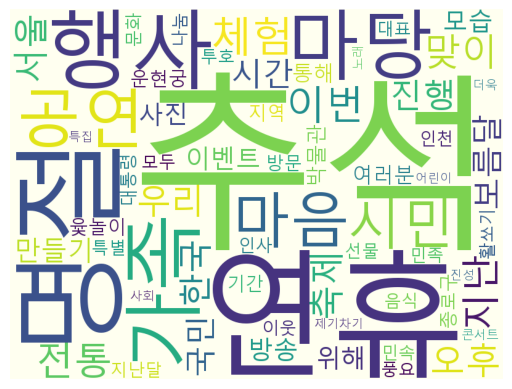

In [8]:
####################### main #####################
# 검색어 입력받기
keyword = input("검색어를 입력하세요 :")
# Naver News Crawling 하기
result_all_list = searchSetNaverNews(keyword)
# JSON 파일로 저장
saveSearchResult(f"{keyword}_news.json", result_all_list)
# 검색 결과에서 본문만 WordCloud 생성하기
visualizeWordCloud(keyword, result_all_list)